In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import pingouin as pg
import scikit_posthocs as sp
from statsmodels.formula.api import ols
from sklearn.utils import resample


# Подготовка данных

In [2]:
df = pd.read_csv('asset-v1_SkillFactory+MFTIBIO+SEP2023+type@asset+block@community_dataset.csv')
df.shape

(269442, 9)

In [3]:
df.head()

,distance_to_vasculature,distance_to_largest_cell,immune_marker_1,immune_marker_2,cell_interaction,cell_type,case_id,area_of_cell,age_group
0,988.509380,612.076506,10.803755,187.998971,community_1,Stroma cells,891,185,elder_group
1,787.852379,637.787202,11.749179,155.357076,community_1,Stroma cells,891,209,elder_group
2,960.635580,700.283468,15.124372,182.626888,community_2,Stroma cells,891,254,elder_group
3,702.033032,676.409695,14.221883,158.381917,community_3,Unclassified,891,156,elder_group
4,830.399371,863.269930,19.978977,159.071269,community_3,Unclassified,891,194,elder_group


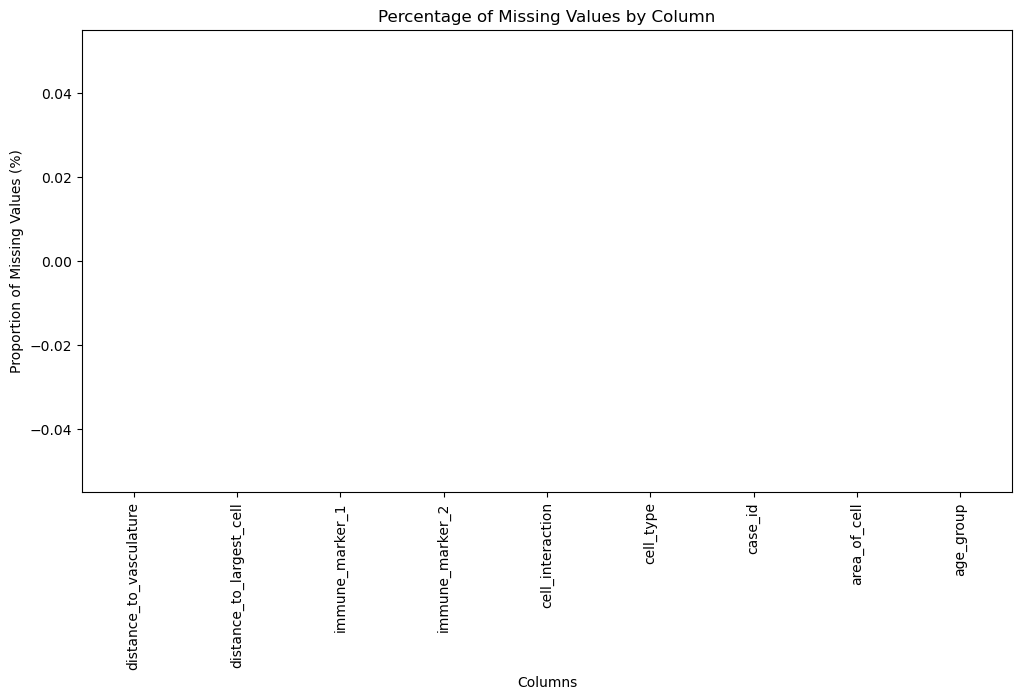

In [4]:
# Вычисляем процент пропущенных значений
percent_missing = df.isnull().mean().sort_values(ascending=False)

# Создаем тепловую карту отсортированных данных
percent_missing.plot(kind='bar', figsize=(12, 6))
plt.ylabel('Proportion of Missing Values (%)')
plt.xlabel('Columns')
plt.title('Percentage of Missing Values by Column')
plt.show()

In [5]:
# Проверка наличия дубликатов и вывод их количества
duplicate_count = df.duplicated().sum()
print("Количество дубликатов:", duplicate_count)

Количество дубликатов: 0


# Задание 1

Есть ли стат-значимость между типом клетки и:

а) Размером клетки (*area_of_cell*), добавьте 'hue' по возрастным группам.

б) Экспрессией иммунных маркеров (*immune_marker_1*, *immune_marker_2*), добавьте 'hue' по возрастным группам.

в) Дистанцией до ближайших объектов (*distance_to_vasculature*, *distance_to_largest_cell*), добавьте hue по возрастным группам.
В качестве ответов можно приводить 'box_plot'/'swarplot', где по одной оси будет тип клеток, а по другой — оцениваемая вами статистика.

## Задание 1_а

Есть ли стат-значимость между типом клетки и размером клетки (*area_of_cell*), добавьте 'hue' по возрастным группам.


In [6]:
data_1 = df[['cell_type', 'area_of_cell', 'age_group']].dropna()
data_1.shape

(269442, 3)

In [7]:
data_1.head(20)

,cell_type,area_of_cell,age_group
0,Stroma cells,185,elder_group
1,Stroma cells,209,elder_group
2,Stroma cells,254,elder_group
3,Unclassified,156,elder_group
4,Unclassified,194,elder_group
5,Unclassified,196,elder_group
6,Stroma cells,238,elder_group
7,Stroma cells,254,elder_group
8,Stroma cells,331,elder_group
9,Unclassified,140,elder_group


### Проверка выборки на нормальность

Построим график размаха (boxplot) для переменных "cell_type" (тип клетки) и "area_of_cell" (размер клетки). Используем параметр hue='age_group' для разделения данных по возрастным группам на том же графике. Это позволит визуально оценить распределение размеров клеток для различных типов клеток и возрастных групп. 

<Axes: xlabel='cell_type', ylabel='area_of_cell'>

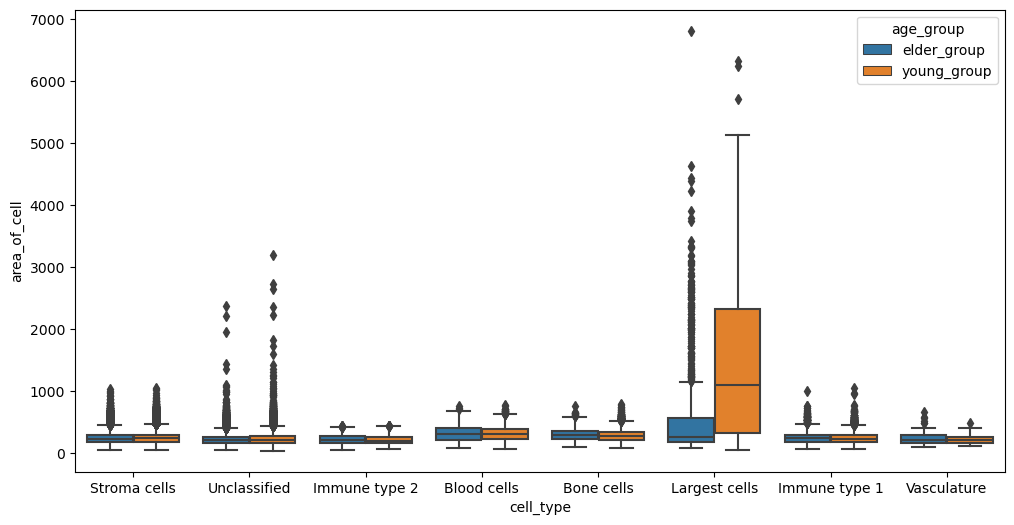

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='cell_type', y='area_of_cell', data=data_1, hue='age_group', ax=ax)

Исходя из графика, можем предположить, что выборка не имеет нормального распределения. Следует проверить ее статистическим тестом и графиками: гистограмм, графиков квантиль-квантиль.

/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Q-Q plot of Area of Cell')

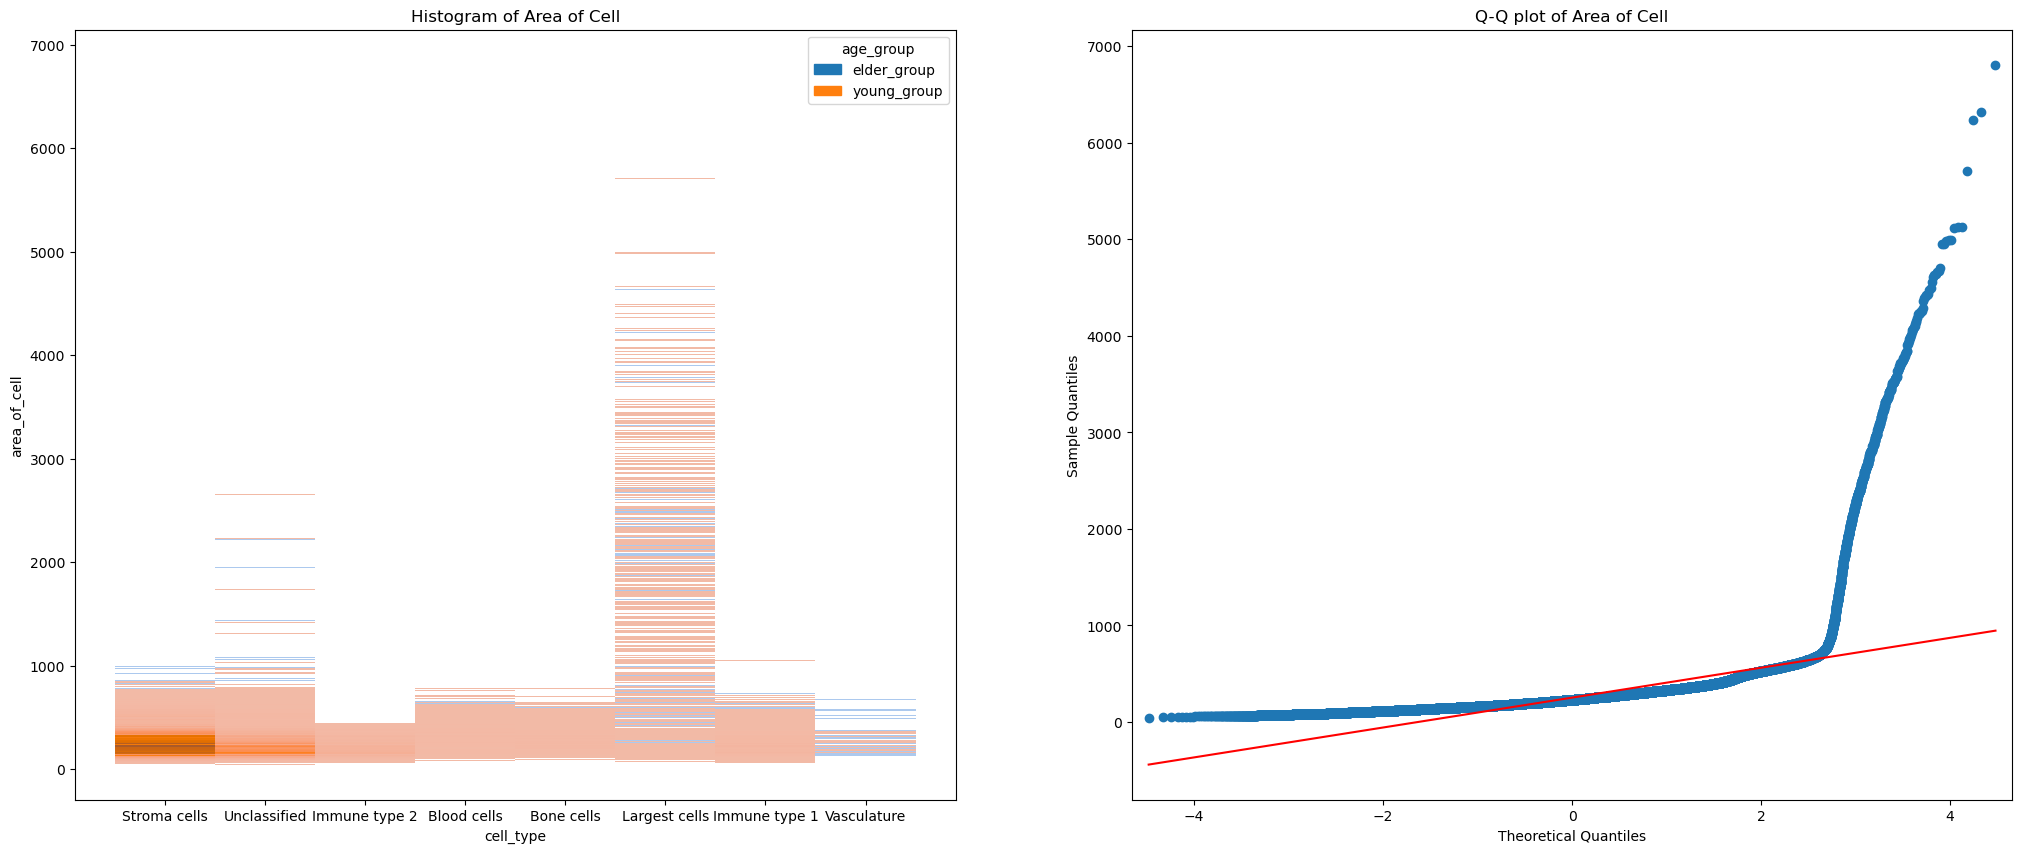

In [9]:
fig, axes = plt.subplots(1, 2,figsize=(25, 10))
sns.histplot(y='area_of_cell', x='cell_type', data=data_1, hue='age_group', ax=axes[0])
axes[0].set_title('Histogram of Area of Cell')

sm.qqplot(data_1['area_of_cell'], line='s', ax=axes[1])
axes[1].set_title('Q-Q plot of Area of Cell')


In [10]:
def normality_disperse_test(data, x, y, hue):
    for cell_type in data[x].unique():
        for age_group in data[hue].unique():
            sample = data[(data[x] == cell_type) & (data[hue] == age_group)][y]
            ks_test_stat, ks_p_value = stats.kstest(sample, 'norm')

            alpha = 0.05

            print(f'alpha: {alpha}')
            print(f'Kolmogorov-Smirnov Test p-value: {ks_p_value}')

            if ks_p_value < alpha:
                print("Распределение является ненормальным")
            else:
                print("Распределение является нормальным")

normality_disperse_test(data_1, 'cell_type', 'area_of_cell', 'age_group')


alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение яв

### Статистический тест

Так как данные являются не нормально распределенными для проверки гипотезы, мы воспользуемся тестом Краскела-Уолисса


In [11]:
def kruskal_test(data, x, y, hue):
    kruskal_results = {}
    
    for cell_type in data[x].unique():
        samples = [data[(data[x] == cell_type) & (data[hue] == age_group)][y]
                   for age_group in data[hue].unique()]
        
        if all(len(sample) > 1 for sample in samples):
            kruskal_test = stats.kruskal(*samples)
            kruskal_results[cell_type] = kruskal_test

    significant_results = {key: value for key, value in kruskal_results.items() if value.pvalue < 0.05}
    non_significant_results = {key: value for key, value in kruskal_results.items() if value.pvalue > 0.05}
    
    print("Статистически значимые результаты:")
    for key, value in significant_results.items():
        print(f"{key}: pvalue = {value.pvalue}")
    
    print("Отсутствие статистической значимости:")
    for key, value in non_significant_results.items():
        print(f"{key}: pvalue = {value.pvalue}")

    return kruskal_results

# Проведем тест Краскела-Уоллиса и выведем результаты
kruskal_results = kruskal_test(data_1, 'cell_type', 'area_of_cell', 'age_group')

Статистически значимые результаты:
Stroma cells: pvalue = 1.6725518119512272e-107
Unclassified: pvalue = 6.328922569995752e-13
Immune type 2: pvalue = 3.0742252797501433e-16
Bone cells: pvalue = 0.003788289886284435
Largest cells: pvalue = 2.9522713980296525e-73
Immune type 1: pvalue = 0.0005129687897256492
Отсутствие статистической значимости:
Blood cells: pvalue = 0.8016989447315541
Vasculature: pvalue = 0.7174489301074176


### *Оценка значимости и величины эффектов

Для оценки величины эффекта теста Краскела-Уоллиса можно использовать коэффициент ранговой корреляции Кендалла (Kendall's W). Этот коэффициент показывает степень согласованности ранжирования значений между группами и может быть полезен для оценки силы связи между группами в тесте Краскела-Уоллиса.

In [12]:
def kendalls_w(kruskal_results, data, x, y, hue): 
    group_ranks = {} 
    group_counts = {} 
    
    for cell_type in data[x].unique(): 
        group_ranks[cell_type] = {}
        
        for age_group in data[hue].unique(): 
            group_data = data[(data[x] == cell_type) & (data[hue] == age_group)]
            group_data_sorted = group_data.sort_values(by=[y])
            group_data_sorted['rank'] = np.arange(1, len(group_data_sorted) + 1)
            group_ranks[cell_type][age_group] = group_data_sorted['rank'].values
        
        group_counts[cell_type] = len(group_data)
    
    Ws = {}
    for cell_type, ranks in group_ranks.items():
        N = sum(group_counts.values())
        overall_mean_rank = sum(np.concatenate(list(ranks.values()))) / N
        S = sum([np.sum((value - overall_mean_rank)**2) for value in ranks.values()])
        W = 12 * S / (N**2 * (N**2 - 1))
        Ws[cell_type] = W
    
    return Ws

# Вычисления Kendall's W 
kendalls_w(kruskal_results, data_1, 'cell_type', 'area_of_cell', 'age_group')


{'Stroma cells': 2.25996366117009e-06,
 'Unclassified': 1.7440754400815835e-07,
 'Immune type 2': 2.972114892471303e-09,
 'Blood cells': 3.778046337048439e-11,
 'Bone cells': 3.146549862355623e-11,
 'Largest cells': 6.328027559607994e-12,
 'Immune type 1': 2.0403441103884945e-10,
 'Vasculature': 2.9375969325830193e-15}

## Задание 1_б

Есть ли стат-значимость между типом клетки и экспрессией иммунных маркеров (*'immune_marker_1'*, *'immune_marker_2'*), добавьте 'hue' по возрастным группам.

In [13]:
df_1_b = df[['cell_type', 'immune_marker_1', 'immune_marker_2', 'age_group']].dropna()
df_1_b.shape

(269442, 4)

In [14]:
df_1_b.head()

,cell_type,immune_marker_1,immune_marker_2,age_group
0,Stroma cells,10.803755,187.998971,elder_group
1,Stroma cells,11.749179,155.357076,elder_group
2,Stroma cells,15.124372,182.626888,elder_group
3,Unclassified,14.221883,158.381917,elder_group
4,Unclassified,19.978977,159.071269,elder_group


Text(0.5, 1.0, 'Boxplot of Immune Marker 2 by Cell Type and Age Group')

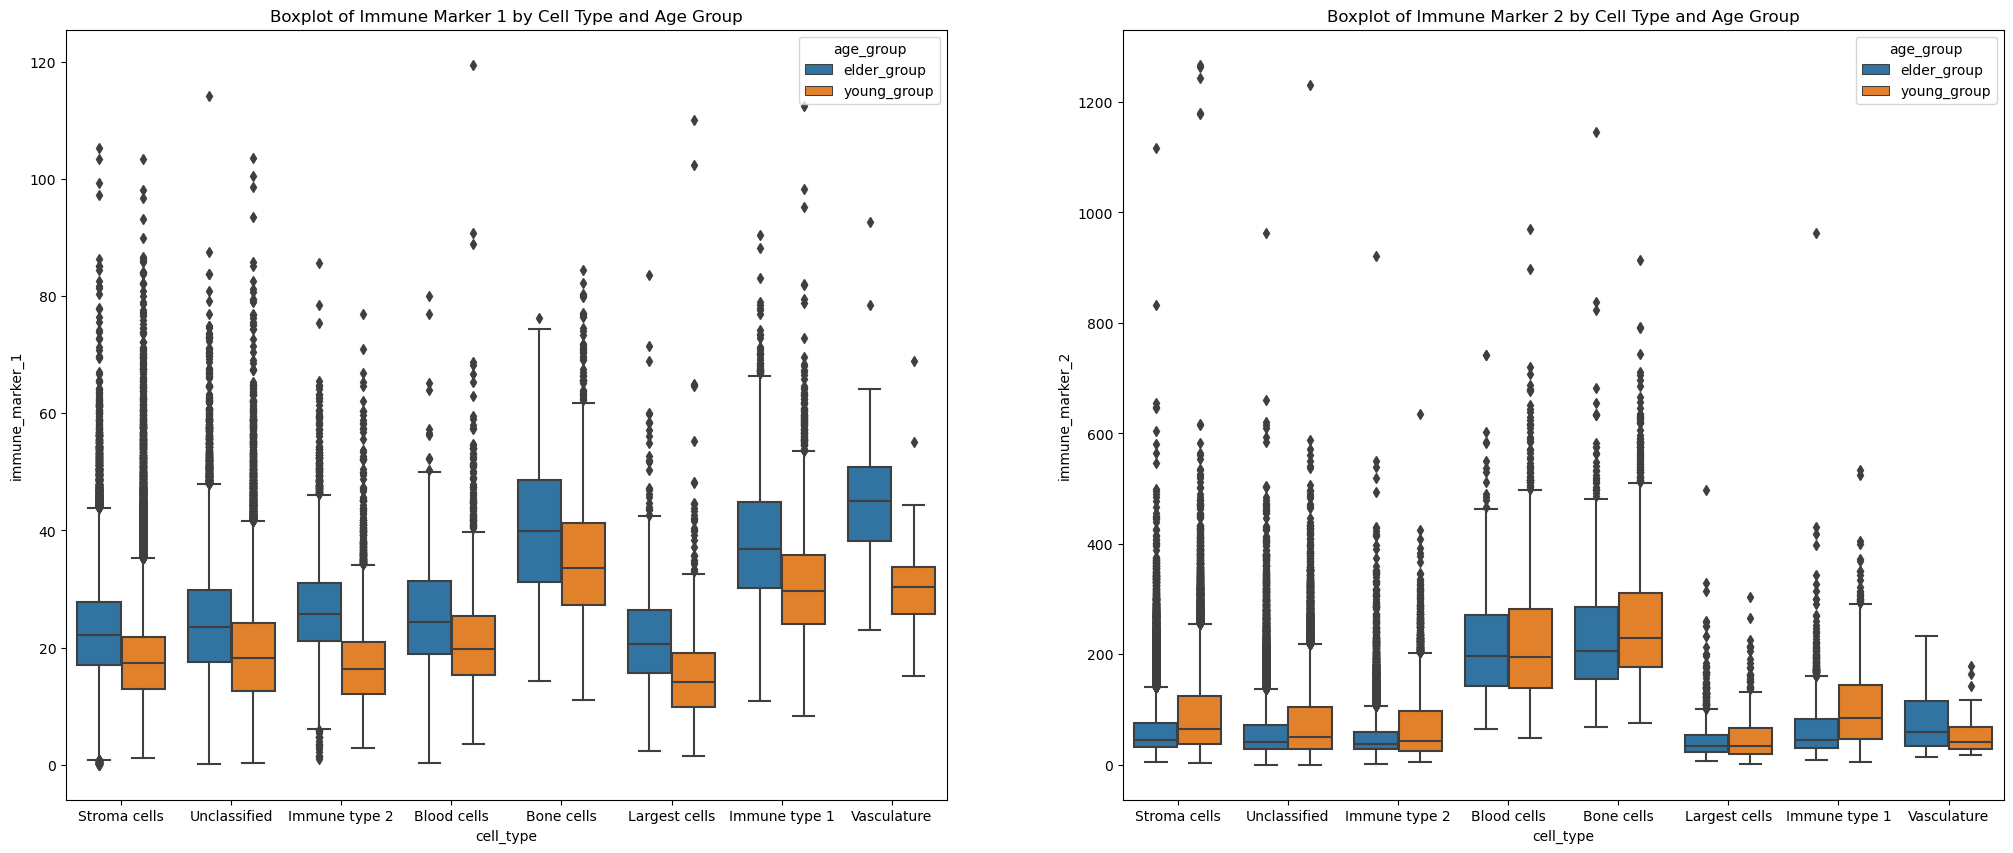

In [15]:
# Cтроим график распределения
fig, axes = plt.subplots(1, 2, figsize=(25, 10))
sns.boxplot(x='cell_type', y='immune_marker_1', data=df_1_b, hue='age_group', ax=axes[0])
axes[0].set_title('Boxplot of Immune Marker 1 by Cell Type and Age Group')

sns.boxplot(x='cell_type', y='immune_marker_2', data=df_1_b, hue='age_group', ax=axes[1])
axes[1].set_title('Boxplot of Immune Marker 2 by Cell Type and Age Group')


### Проверка выборки на нормальность

По графикам выше, можно преположить, что выборки не подчиняются закону нормального распределения. Для проверки распределения выборки используем статистический тест и графики: гистограммы, графики квантиль-квантиль.

/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

Text(0.5, 1.0, 'Q-Q plot of immune_marker_2')

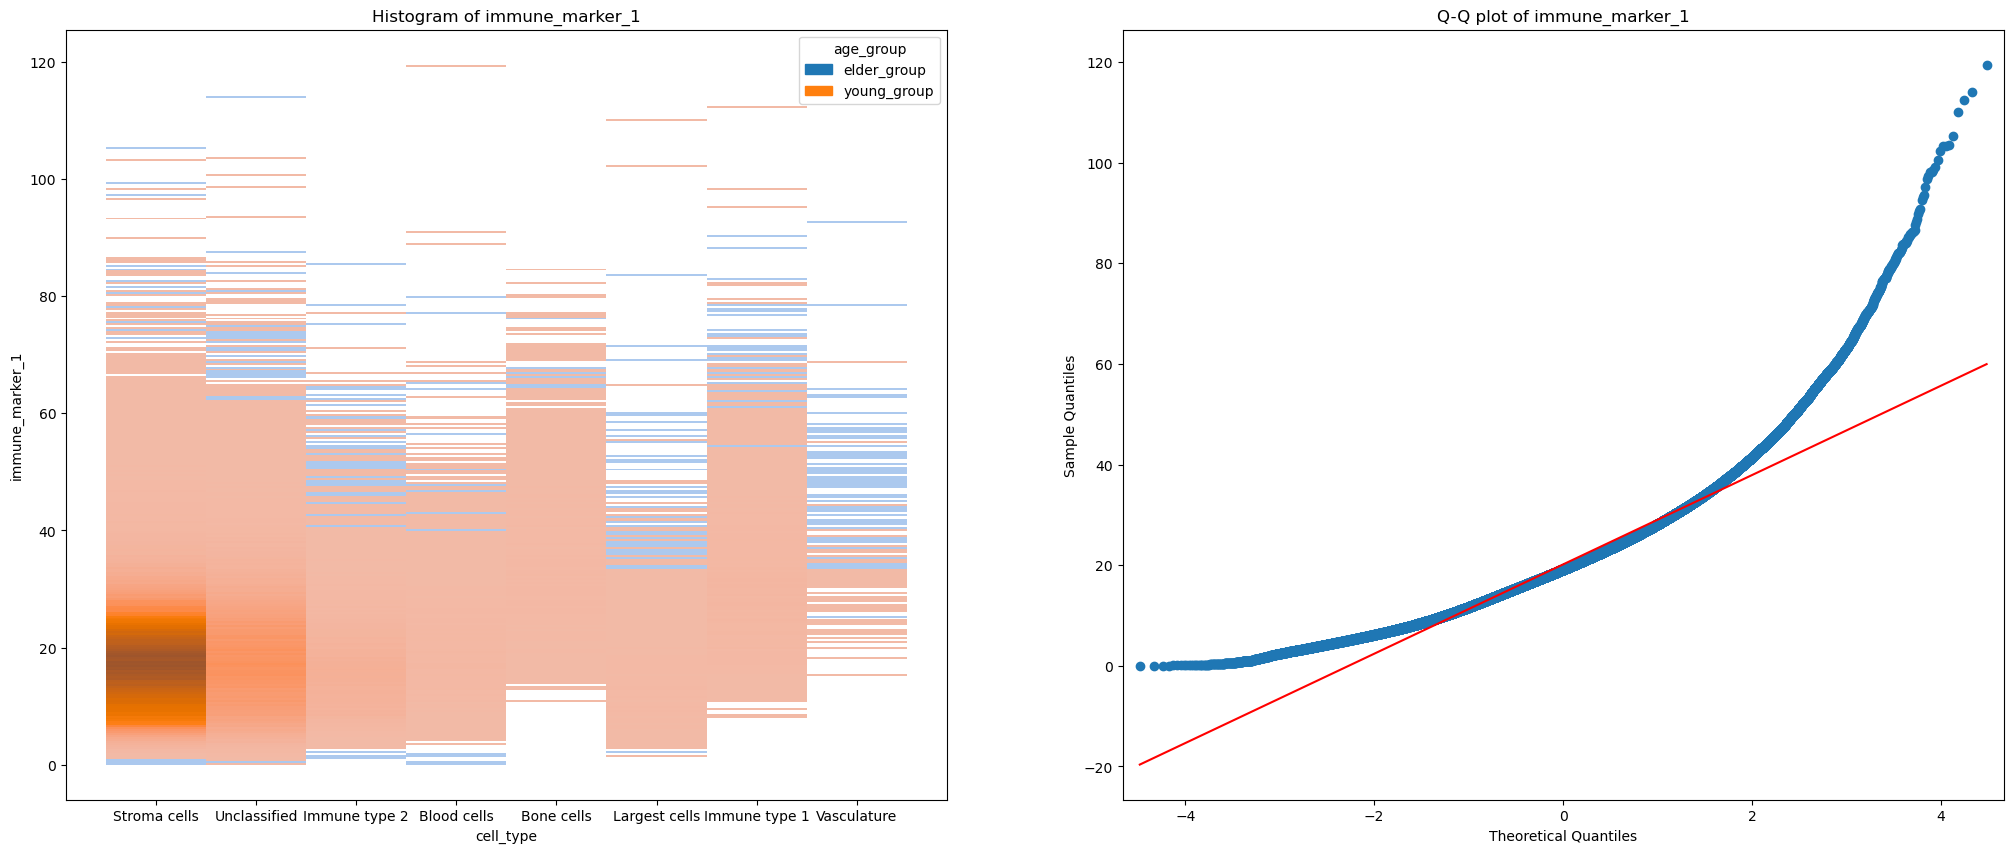

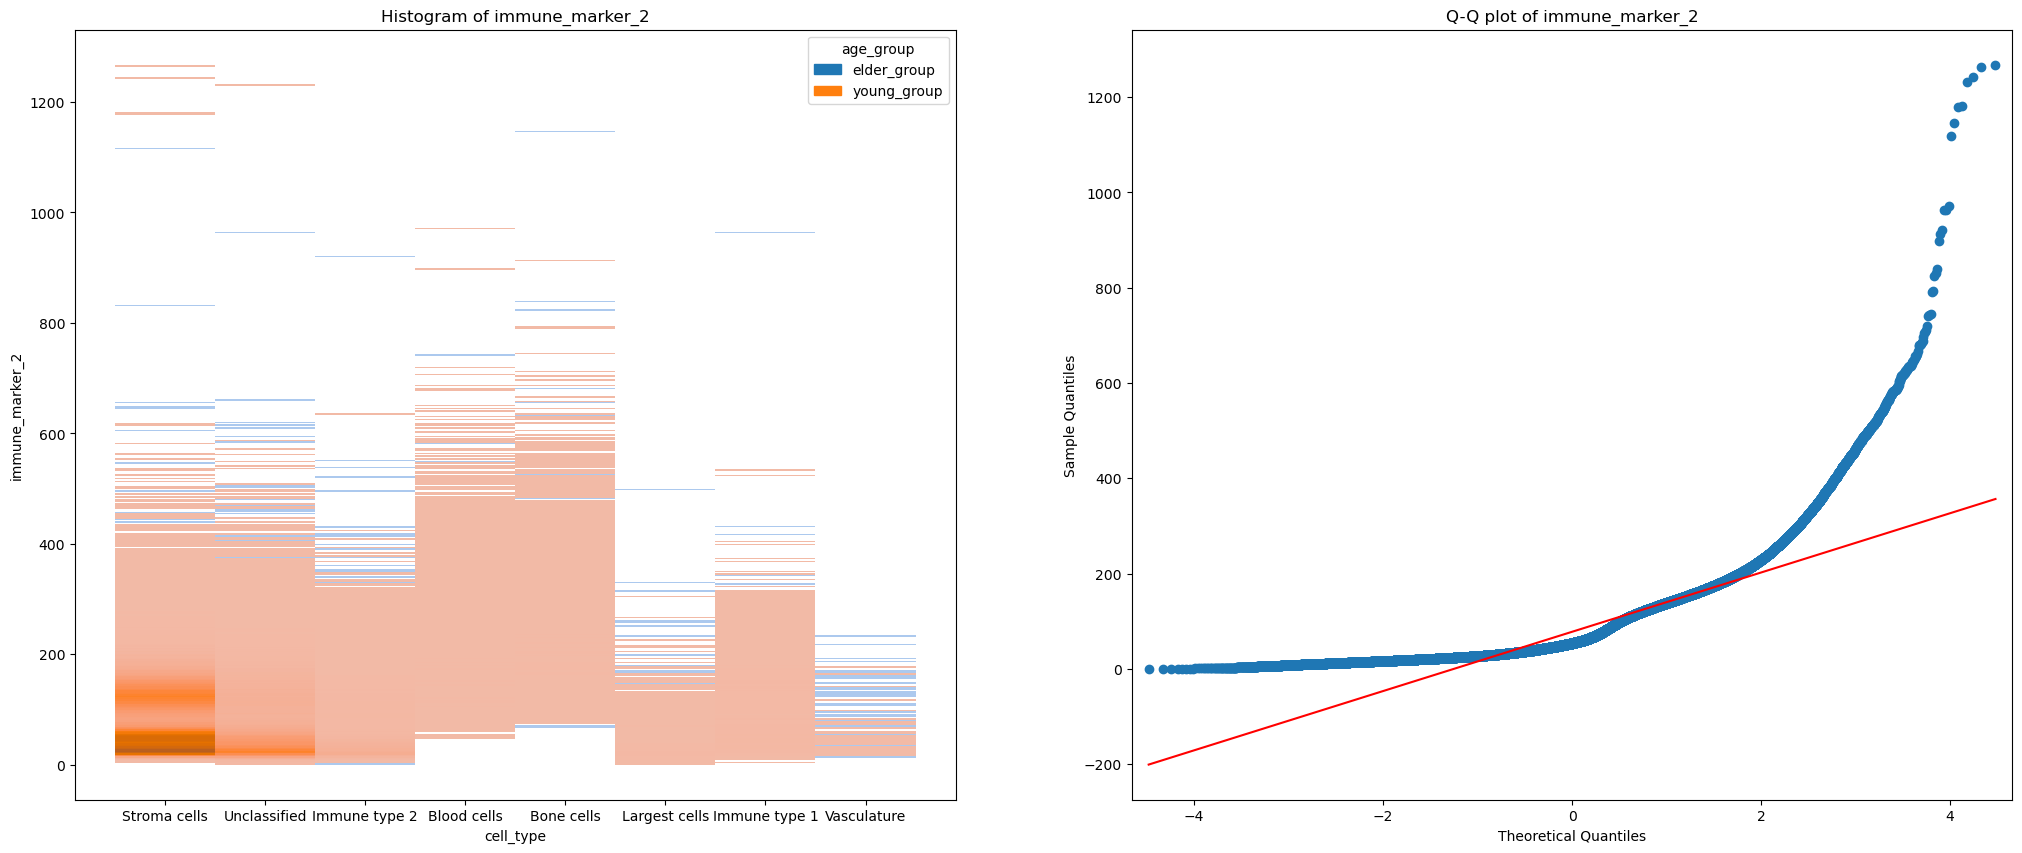

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(25, 10))
sns.histplot(x='cell_type', y='immune_marker_1', data=df_1_b, hue='age_group', ax=axes[0])
axes[0].set_title('Histogram of immune_marker_1')

sm.qqplot(df_1_b['immune_marker_1'], line='s', ax=axes[1])
axes[1].set_title('Q-Q plot of immune_marker_1')

fig, axes = plt.subplots(1, 2, figsize=(25, 10))
sns.histplot(x='cell_type', y='immune_marker_2', data=df_1_b, hue='age_group', ax=axes[0])
axes[0].set_title('Histogram of immune_marker_2')

sm.qqplot(df_1_b['immune_marker_2'], line='s', ax=axes[1])
axes[1].set_title('Q-Q plot of immune_marker_2')

In [17]:
normality_disperse_test(df_1_b, 'cell_type', 'immune_marker_1', 'age_group')

alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение яв

In [18]:
normality_disperse_test(df_1_b, 'cell_type', 'immune_marker_2', 'age_group')

alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение яв

### Статистический тест

Так как данные не подчиняются нормальному закону распределения проведем непараметрический тест Краскела-Уоллиса

In [19]:
kruskal_results = kruskal_test(df_1_b, 'cell_type', 'immune_marker_1', 'age_group')

Статистически значимые результаты:
Stroma cells: pvalue = 0.0
Unclassified: pvalue = 0.0
Immune type 2: pvalue = 0.0
Blood cells: pvalue = 1.8056797201268765e-27
Bone cells: pvalue = 1.9728772543745173e-17
Largest cells: pvalue = 8.304262271507349e-76
Immune type 1: pvalue = 7.744067153278382e-126
Vasculature: pvalue = 1.515417956543255e-14
Отсутствие статистической значимости:


In [20]:
kruskal_results = kruskal_test(df_1_b, 'cell_type', 'immune_marker_2', 'age_group')

Статистически значимые результаты:
Stroma cells: pvalue = 0.0
Unclassified: pvalue = 1.2398323559885132e-87
Immune type 2: pvalue = 4.999100708526236e-10
Bone cells: pvalue = 0.0001943234704689618
Immune type 1: pvalue = 7.190618242210395e-97
Vasculature: pvalue = 0.016588390080277366
Отсутствие статистической значимости:
Blood cells: pvalue = 0.8301585171693324
Largest cells: pvalue = 0.4953407810463696


### *Оценка значимости и величины эффектов

In [21]:
kendalls_w(kruskal_results, df_1_b, 'cell_type', 'immune_marker_1', 'age_group')

{'Stroma cells': 2.25996366117009e-06,
 'Unclassified': 1.7440754400815835e-07,
 'Immune type 2': 2.972114892471303e-09,
 'Blood cells': 3.778046337048439e-11,
 'Bone cells': 3.146549862355623e-11,
 'Largest cells': 6.328027559607994e-12,
 'Immune type 1': 2.0403441103884945e-10,
 'Vasculature': 2.9375969325830193e-15}

In [22]:
kendalls_w(kruskal_results, df_1_b, 'cell_type', 'immune_marker_2', 'age_group')

{'Stroma cells': 2.25996366117009e-06,
 'Unclassified': 1.7440754400815835e-07,
 'Immune type 2': 2.972114892471303e-09,
 'Blood cells': 3.778046337048439e-11,
 'Bone cells': 3.146549862355623e-11,
 'Largest cells': 6.328027559607994e-12,
 'Immune type 1': 2.0403441103884945e-10,
 'Vasculature': 2.9375969325830193e-15}

## Задание 1_в

Есть ли стат-значимость между типом клетки и дистанцией до ближайших объектов ('*distance_to_vasculature*', '*distance_to_largest_cell*'), добавьте 'hue' по возрастным группам.

In [23]:
df_1_v = df[['cell_type', 'distance_to_vasculature','distance_to_largest_cell', 'age_group']].dropna()
df_1_v.shape

(269442, 4)

In [24]:
df_1_v.head()

,cell_type,distance_to_vasculature,distance_to_largest_cell,age_group
0,Stroma cells,988.509380,612.076506,elder_group
1,Stroma cells,787.852379,637.787202,elder_group
2,Stroma cells,960.635580,700.283468,elder_group
3,Unclassified,702.033032,676.409695,elder_group
4,Unclassified,830.399371,863.269930,elder_group


Text(0.5, 1.0, 'Boxplot of Distance to Largest Cell by Cell Type and Age Group')

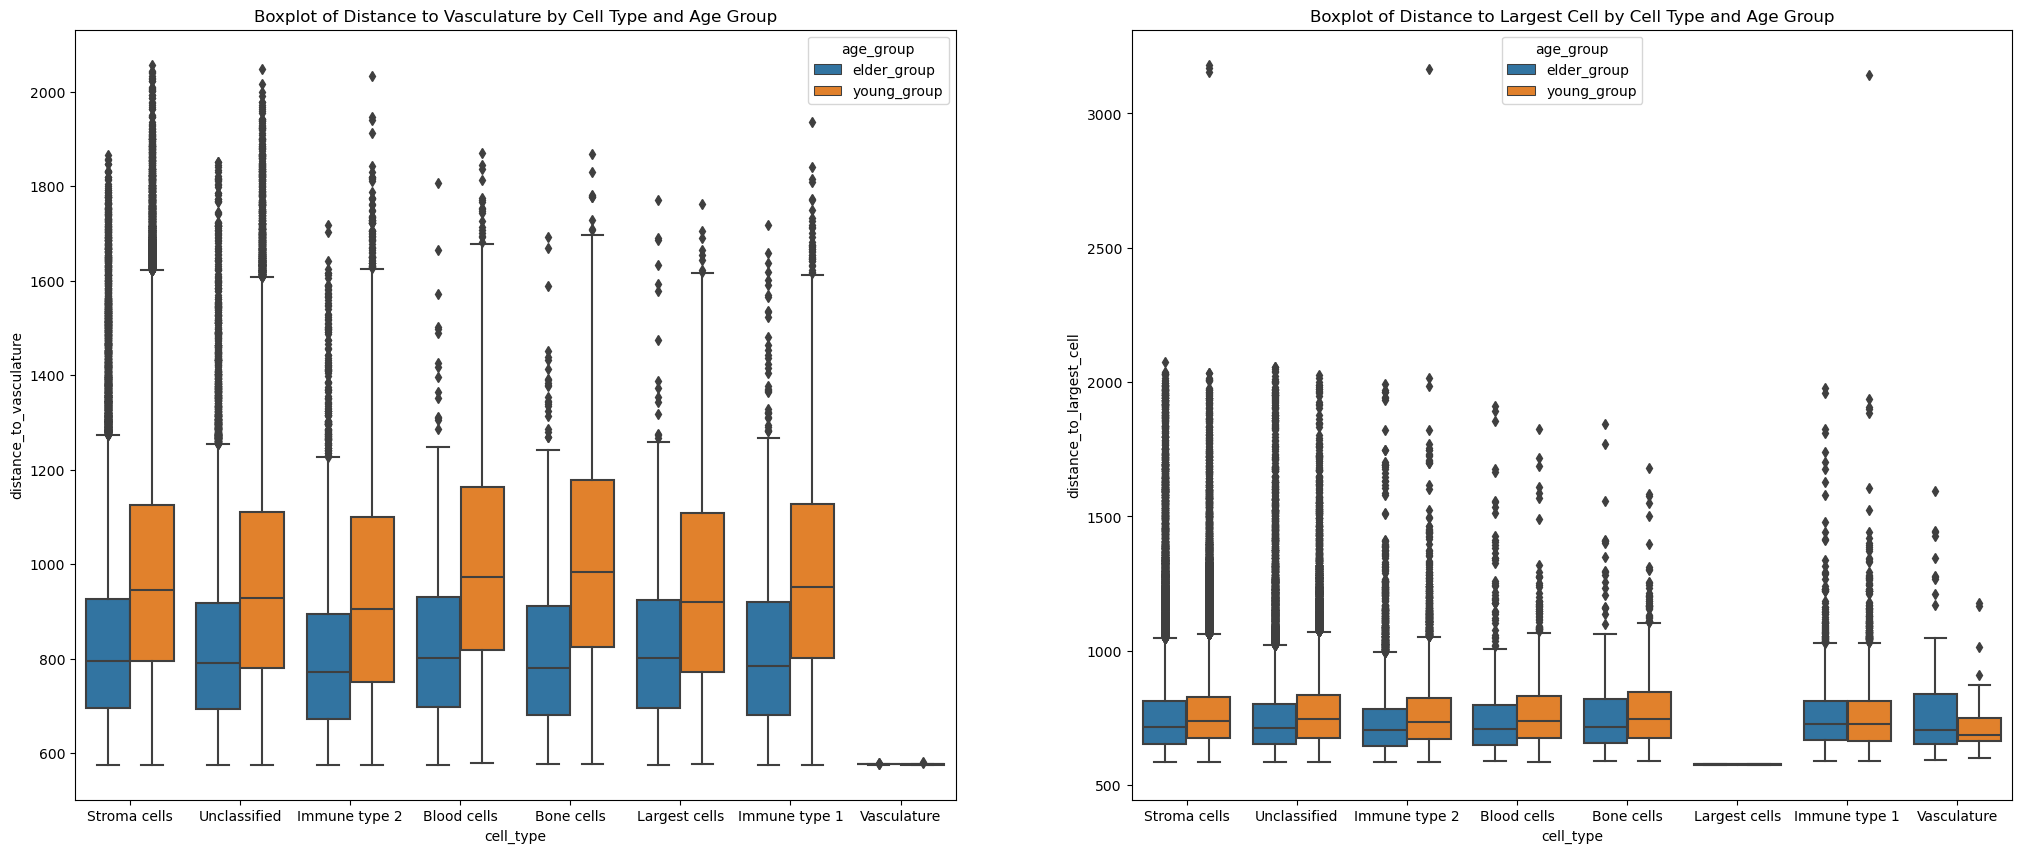

In [25]:
# Cтроим график распределения
fig, axes = plt.subplots(1, 2, figsize=(25, 10))
sns.boxplot(x='cell_type', y='distance_to_vasculature', data=df_1_v, hue='age_group', ax=axes[0])
axes[0].set_title('Boxplot of Distance to Vasculature by Cell Type and Age Group')

sns.boxplot(x='cell_type', y='distance_to_largest_cell', data=df_1_v, hue='age_group', ax=axes[1])
axes[1].set_title('Boxplot of Distance to Largest Cell by Cell Type and Age Group')


### Проверка выборки на нормальность

По графикам выше, можно преположить, что выборки не подчиняются закону нормального распределения. Для проверки распределения выборки используем статистический тест и графики: гистограммы, графики квантиль-квантиль.

/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

Text(0.5, 1.0, 'Q-Q plot of Distance to Largest Cell')

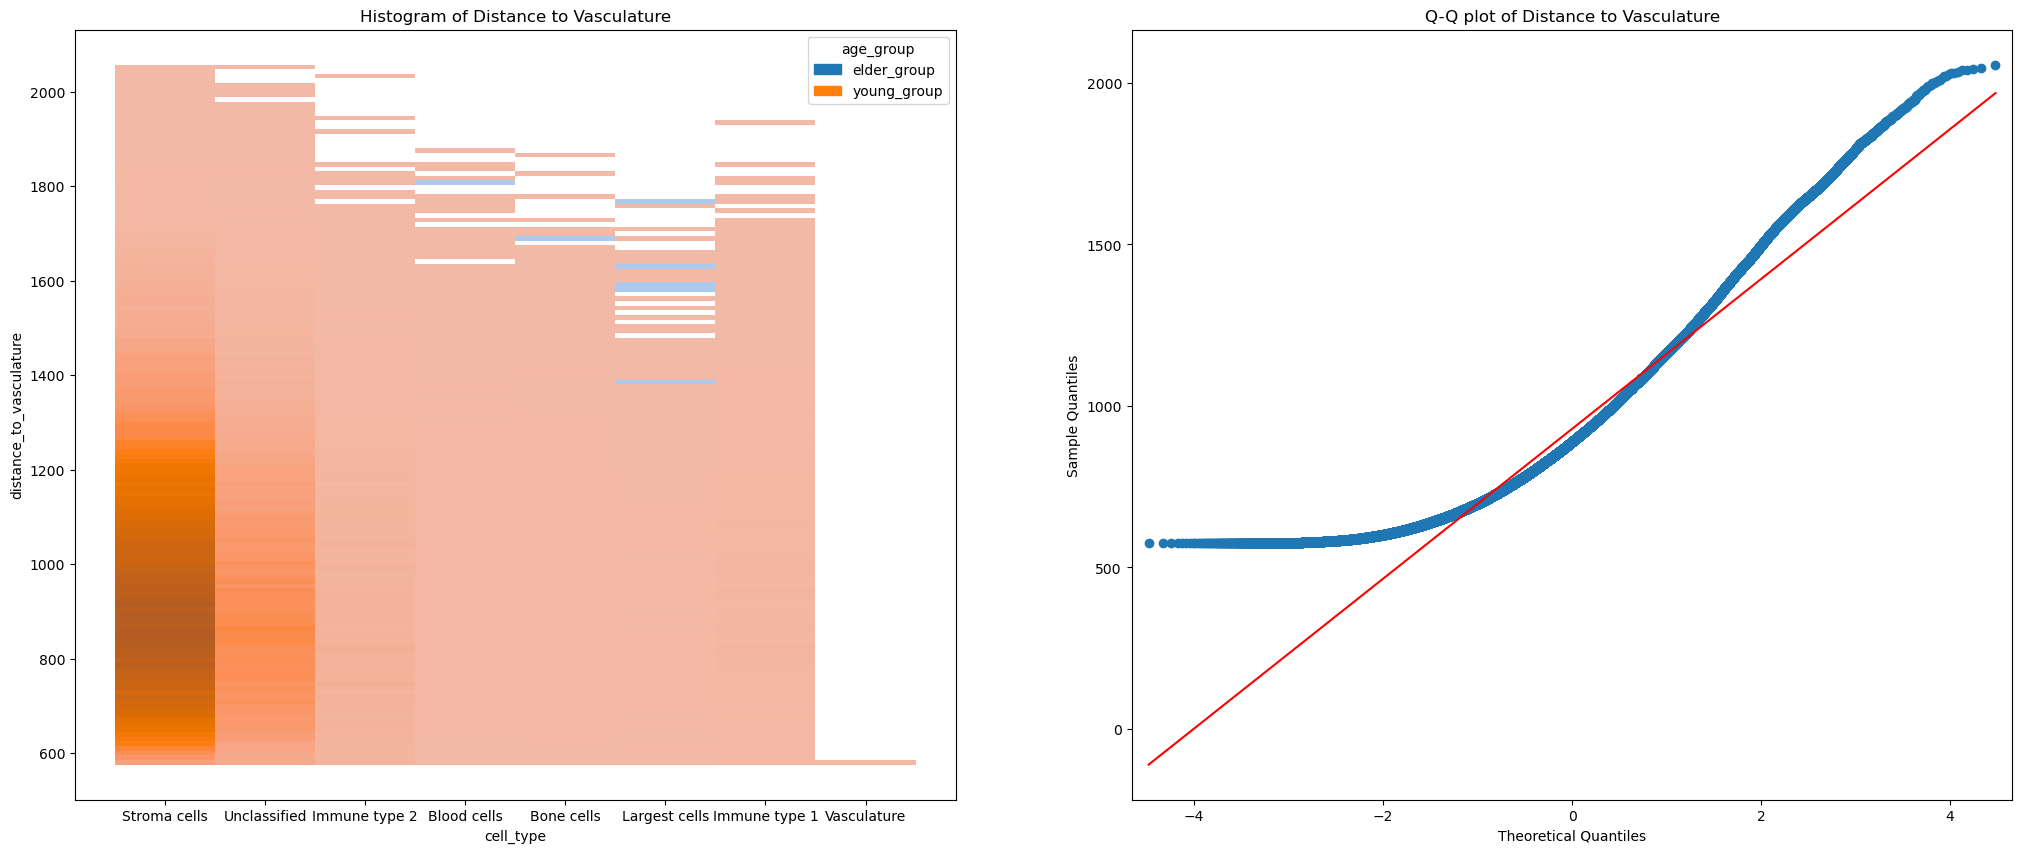

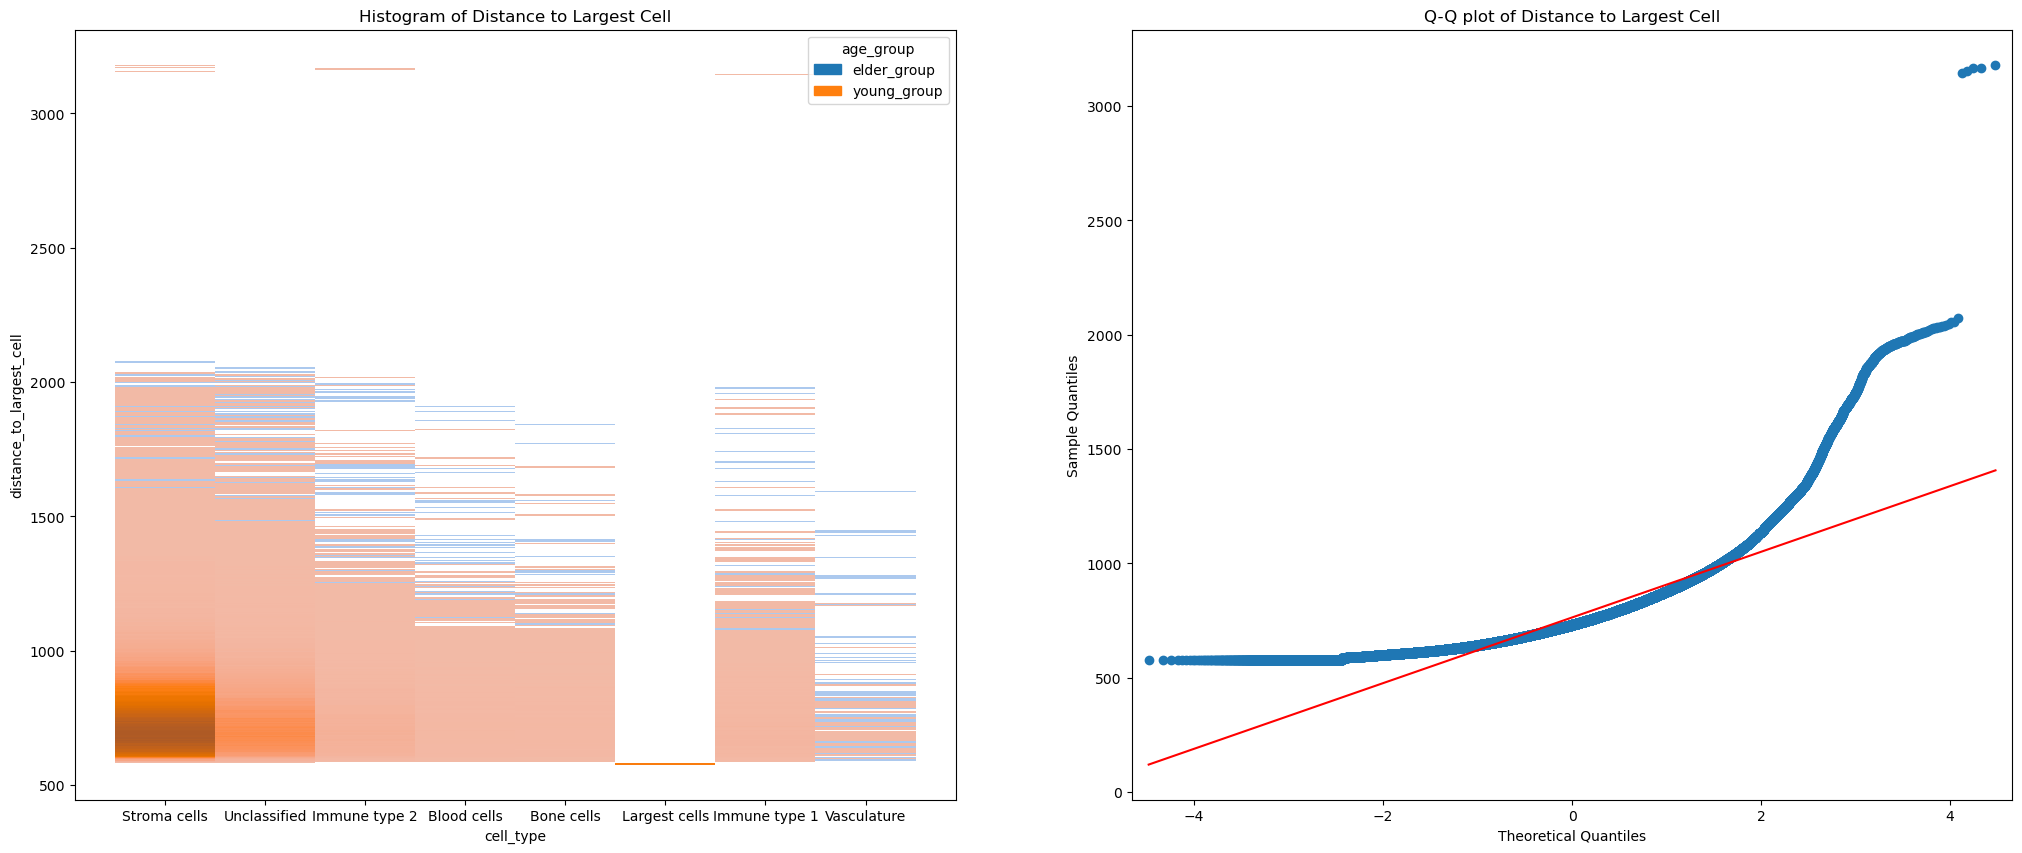

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(25, 10))
sns.histplot(x='cell_type', y='distance_to_vasculature', data=df_1_v, hue='age_group', ax=axes[0])
axes[0].set_title('Histogram of Distance to Vasculature')

sm.qqplot(df_1_v['distance_to_vasculature'], line='s', ax=axes[1])
axes[1].set_title('Q-Q plot of Distance to Vasculature')

fig, axes = plt.subplots(1, 2, figsize=(25, 10))
sns.histplot(x='cell_type', y='distance_to_largest_cell', data=df_1_v, hue='age_group', ax=axes[0])
axes[0].set_title('Histogram of Distance to Largest Cell')

sm.qqplot(df_1_v['distance_to_largest_cell'], line='s', ax=axes[1])
axes[1].set_title('Q-Q plot of Distance to Largest Cell')

In [27]:
normality_disperse_test(df_1_v, 'cell_type', 'distance_to_vasculature', 'age_group')

alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение яв

In [28]:
normality_disperse_test(df_1_v, 'cell_type', 'distance_to_largest_cell', 'age_group')

alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение является ненормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.0
Распределение яв

### Статистический тест
Так как данные не подчиняются нормальному закону распределения проведем непараметрический тест Краскела-Уоллиса

In [29]:
kruskal_results = kruskal_test(df_1_v, 'cell_type', 'distance_to_vasculature', 'age_group')

Статистически значимые результаты:
Stroma cells: pvalue = 0.0
Unclassified: pvalue = 0.0
Immune type 2: pvalue = 0.0
Blood cells: pvalue = 9.413917594004068e-53
Bone cells: pvalue = 2.1265074512275832e-47
Largest cells: pvalue = 8.562546860055077e-36
Immune type 1: pvalue = 2.3126973687393413e-132
Отсутствие статистической значимости:
Vasculature: pvalue = 0.1477833285998148


In [30]:
kruskal_results = kruskal_test(df_1_v, 'cell_type', 'distance_to_largest_cell', 'age_group')

Статистически значимые результаты:
Stroma cells: pvalue = 2.7263427227421726e-240
Unclassified: pvalue = 3.8058918867435395e-222
Immune type 2: pvalue = 6.692959547992128e-74
Blood cells: pvalue = 2.109205999148913e-06
Bone cells: pvalue = 8.453471592890127e-05
Отсутствие статистической значимости:
Largest cells: pvalue = 0.9084008140485378
Immune type 1: pvalue = 0.8843513008366265
Vasculature: pvalue = 0.2544429684704008


### *Оценка значимости и величины эффектов

In [31]:
kendalls_w(kruskal_results, df_1_v, 'cell_type', 'distance_to_vasculature', 'age_group')

{'Stroma cells': 2.25996366117009e-06,
 'Unclassified': 1.7440754400815835e-07,
 'Immune type 2': 2.972114892471303e-09,
 'Blood cells': 3.778046337048439e-11,
 'Bone cells': 3.146549862355623e-11,
 'Largest cells': 6.328027559607994e-12,
 'Immune type 1': 2.0403441103884945e-10,
 'Vasculature': 2.9375969325830193e-15}

In [32]:
kendalls_w(kruskal_results, df_1_v, 'cell_type', 'distance_to_largest_cell', 'age_group')

{'Stroma cells': 2.25996366117009e-06,
 'Unclassified': 1.7440754400815835e-07,
 'Immune type 2': 2.972114892471303e-09,
 'Blood cells': 3.778046337048439e-11,
 'Bone cells': 3.146549862355623e-11,
 'Largest cells': 6.328027559607994e-12,
 'Immune type 1': 2.0403441103884945e-10,
 'Vasculature': 2.9375969325830193e-15}

# Задание 2

В каком клеточном микроокружении клеток какого типа статистически больше, чем в других микроокружениях? (колонка *cell_interaction*). Для ответа используйте box_plot/swarplot с hue по микроокружениям, где:

- по $O_x$ будут типы клеток,
- по $O_y$ — их количество.

Не забудьте посчитать количество для каждого пациента отдельно, иначе выборка не будет репрезентативной.

In [33]:
# Подсчет количества клеток каждого типа в каждом клеточном микроокружении для каждого пациента
cell_count = df.groupby(['case_id', 'cell_type', 'cell_interaction']).size().reset_index(name='count')

In [34]:
type(cell_count)

pandas.core.frame.DataFrame

Text(0.5, 1.0, 'Distribution of the count of cells by type and cell interaction')

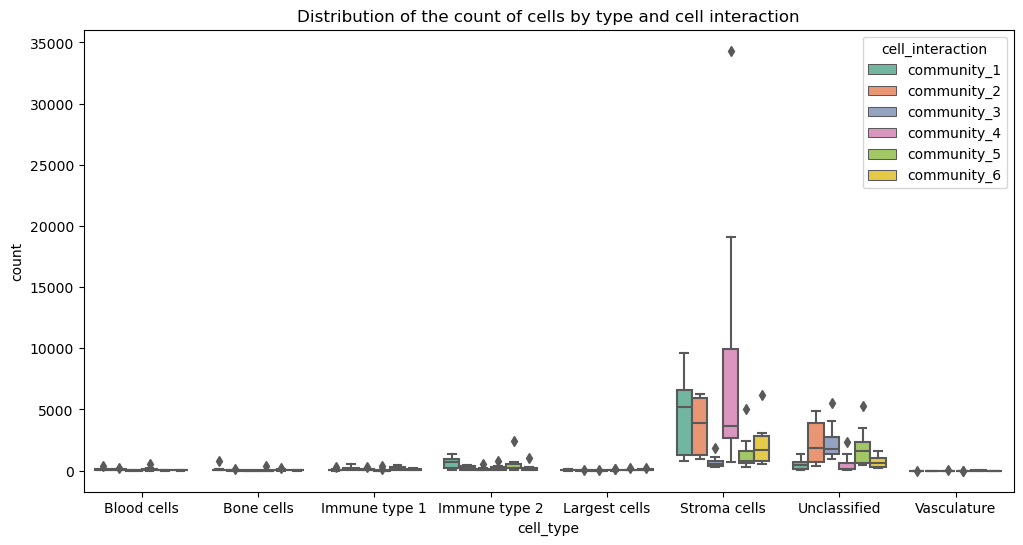

In [35]:
# Построим boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='cell_type', y='count', hue='cell_interaction', data=cell_count, palette="Set2")
plt.title('Distribution of the count of cells by type and cell interaction')


/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


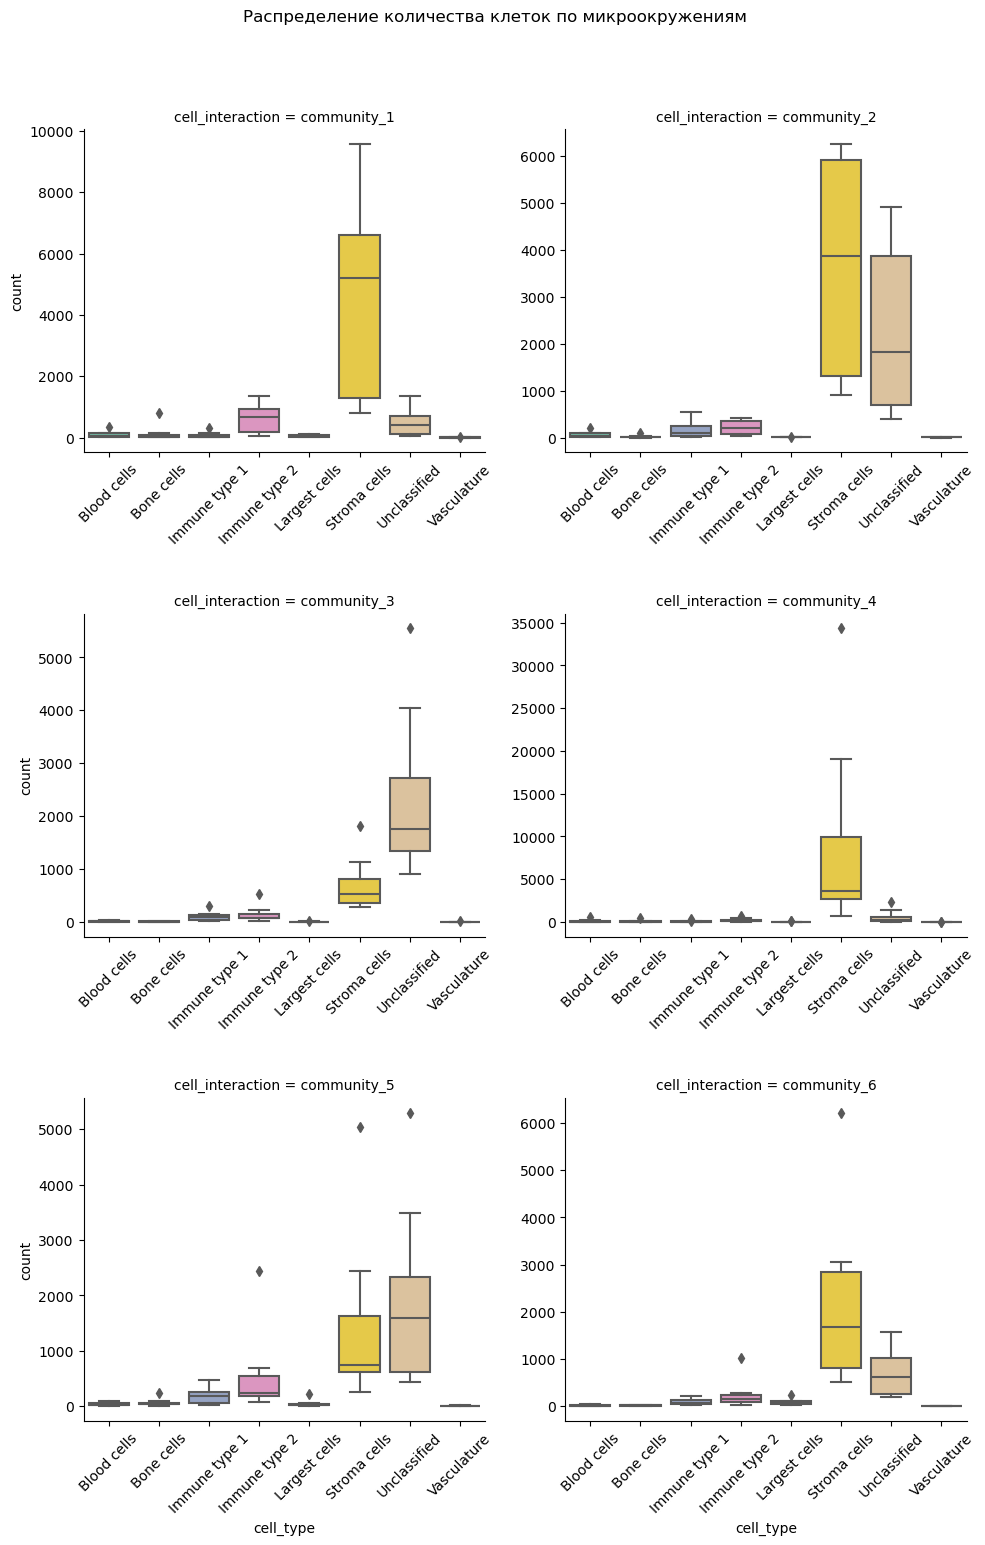

In [36]:
# Построим графики для каждого микроокружения
g = sns.FacetGrid(cell_count, col="cell_interaction", col_wrap=2, sharex=False, sharey=False, height=5, aspect=1)
g.map(sns.boxplot, "cell_type", "count", palette="Set2")

plt.subplots_adjust(top=0.9)
g.figure.suptitle('Распределение количества клеток по микроокружениям')
g.figure.subplots_adjust(hspace=0.5, wspace=0.2)

for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


По графикам выше можно сделать следующие выводы о среднем количестве клеток:

- В микроокружении 4 статистически больше чем в других микроокружениях клеток типа *Stroma Cells*;

- В микроокружении 2 статистически больше чем в других микроокружениях клеток типа *Unclassified*;

- В микроокружении 1 статистически больше чем в других микроокружениях клеток типа *Immune type 2*;

- В микроокружении 5 статистически больше чем в других микроокружениях клеток типа *Immune type 1*;

- остальные типы клеток содержатся в очень малом количестве во всех микроокруженях.



## Проверка выборки на нормальность

In [37]:
cell_count.head(20)

,case_id,cell_type,cell_interaction,count
0,40,Blood cells,community_1,37
1,40,Blood cells,community_2,40
2,40,Blood cells,community_3,20
3,40,Blood cells,community_4,18
4,40,Blood cells,community_5,77
5,40,Blood cells,community_6,36
6,40,Bone cells,community_1,27
7,40,Bone cells,community_2,10
8,40,Bone cells,community_3,12
9,40,Bone cells,community_4,3


In [38]:
# Получение уникальных значений для типов клеток и микроокружений из исходных данных
cell_types = cell_count['cell_type'].unique()
interactions = cell_count['cell_interaction'].unique()

ks_results = pd.DataFrame(index=cell_types, columns=interactions)

for cell_type in cell_types:
    for interaction in interactions:
        # Фильтруем по типу клетки и микроокружению
        sample1 = cell_count[(cell_count['cell_type'] == cell_type) & (cell_count['cell_interaction'] == interaction)]['count']
        sample2 = cell_count[(cell_count['cell_type'] != cell_type) & (cell_count['cell_interaction'] == interaction)]['count']
        if len(sample1) < 3 or len(sample2) < 3:
            ks_results.loc[cell_type, interaction] = None
            continue
        # Applying the Kolmogorov-Smirnov test and saving the p-value
        stat, p = stats.ks_2samp(sample1, sample2)
        ks_results.loc[cell_type, interaction] = p

In [39]:
ks_results

,community_1,community_2,community_3,community_4,community_5,community_6
Blood cells,0.285776,0.133113,0.018527,0.665419,0.017836,0.002596
Bone cells,0.427856,0.041774,0.000805,0.043421,0.121758,0.000443
Immune type 1,0.103316,0.166655,0.035001,0.187236,0.47815,0.346772
Immune type 2,0.02797,0.027012,0.018527,0.197141,0.017836,0.232798
Largest cells,0.030019,0.000984,0.005612,0.178573,0.074493,0.267148
Stroma cells,0.000001,0.000001,0.000033,0.0,0.00021,0.000001
Unclassified,0.085645,0.000025,0.0,0.122749,0.000041,0.000271
Vasculature,0.000003,0.0,0.005695,0.000316,0.000003,0.000001


В большинстве случаев данные распределенны не нормально

## Статистический тест

In [40]:
# Создаем пустой список для хранения результатов
results_list = []

# Получаем уникальные значения для 'cell_type'
unique_cell_types = cell_count['cell_type'].unique()

# Проходим по каждому типу клеток
for cell_type in unique_cell_types:
    # Отфильтровываем данные по типу клетки
    cell_type_data = cell_count[cell_count['cell_type'] == cell_type]
    
    # Подготавливаем данные для теста Краскела-Уоллиса
    interaction_data = [group['count'].values for name, group in cell_type_data.groupby('cell_interaction')]
    
    # Проводим тест Краскела-Уоллиса
    k_stat, p_value = stats.kruskal(*interaction_data)
    print(f'Kruskal-Wallis test for cell type {cell_type}: K-statistic: {k_stat}, P-value: {p_value}')
    
    # Если p-value меньше 0.05, проводим тест Данна
    if p_value < 0.05:
        print(f'Performing post-hoc Dunn test for cell type {cell_type}')
        p_values = sp.posthoc_dunn(cell_type_data, val_col='count', group_col='cell_interaction')
        # Собираем результаты в список словарей
        for i, row in p_values.iterrows():
            for col in p_values.columns:
                if i != col:  # Исключаем сравнение группы с самой собой
                    results_list.append({
                        'cell_type': cell_type,
                        'group1': i,
                        'group2': col,
                        'p_value': row[col]
                    })

# Преобразуем список словарей в DataFrame
results_df = pd.DataFrame(results_list)

# Создаем сводную таблицу результатов
pivot_table = results_df.pivot(index=['cell_type', 'group1'], columns='group2', values='p_value')

Kruskal-Wallis test for cell type Blood cells: K-statistic: 13.595872269911977, P-value: 0.018390883472722126
Performing post-hoc Dunn test for cell type Blood cells
Kruskal-Wallis test for cell type Bone cells: K-statistic: 16.995067617636135, P-value: 0.004509160881281219
Performing post-hoc Dunn test for cell type Bone cells
Kruskal-Wallis test for cell type Immune type 1: K-statistic: 9.94262662179033, P-value: 0.07687731356218432
Kruskal-Wallis test for cell type Immune type 2: K-statistic: 8.730539572250546, P-value: 0.12030688182646924
Kruskal-Wallis test for cell type Largest cells: K-statistic: 23.78865699222782, P-value: 0.00023838374262455457
Performing post-hoc Dunn test for cell type Largest cells
Kruskal-Wallis test for cell type Stroma cells: K-statistic: 18.727040816326507, P-value: 0.0021605838372889432
Performing post-hoc Dunn test for cell type Stroma cells
Kruskal-Wallis test for cell type Unclassified: K-statistic: 18.966836734693857, P-value: 0.0019496673303232715

In [41]:
pivot_table[pivot_table < 0.05]

group2                     community_1  community_2  community_3  community_4  \
cell_type     group1                                                            
Blood cells   community_1          NaN          NaN     0.002184          NaN   
              community_2          NaN          NaN     0.014741          NaN   
              community_3     0.002184     0.014741          NaN     0.024379   
              community_4          NaN          NaN     0.024379          NaN   
              community_5          NaN          NaN     0.022733          NaN   
              community_6     0.020203          NaN          NaN          NaN   
Bone cells    community_1          NaN     0.020831     0.003983     0.034051   
              community_2     0.020831          NaN          NaN          NaN   
              community_3     0.003983          NaN          NaN          NaN   
              community_4     0.034051          NaN          NaN          NaN   
              community_5          NaN     0.008830     0.001438     0.016209   
              community_6          NaN          NaN          NaN          NaN   
Largest cells community_1          NaN     0.034981     0.006089          NaN   
              community_2     0.034981          NaN          NaN          NaN   
              community_3     0.006089          NaN          NaN     0.044400   
              community_4          NaN          NaN     0.044400          NaN   
              community_5          NaN     0.038188     0.006785          NaN   
              community_6          NaN     0.000317     0.000023     0.026100   
Stroma cells  community_1          NaN          NaN     0.001154          NaN   
              community_2          NaN          NaN     0.003215          NaN   
              community_3     0.001154     0.003215          NaN     0.001154   
              community_4          NaN          NaN     0.001154          NaN   
              community_5     0.016718     0.036682          NaN     0.016718   
              community_6          NaN          NaN          NaN          NaN   
Unclassified  community_1          NaN     0.013059     0.003405          NaN   
              community_2     0.013059          NaN          NaN     0.006642   
              community_3     0.003405          NaN          NaN     0.001574   
              community_4          NaN     0.006642     0.001574          NaN   
              community_5     0.021247          NaN          NaN     0.011222   
              community_6          NaN          NaN     0.023338          NaN   

group2                     community_5  community_6  
cell_type     group1                                 
Blood cells   community_1          NaN     0.020203  
              community_2          NaN          NaN  
              community_3     0.022733          NaN  
              community_4          NaN          NaN  
              community_5          NaN          NaN  
              community_6          NaN          NaN  
Bone cells    community_1          NaN          NaN  
              community_2     0.008830          NaN  
              community_3     0.001438          NaN  
              community_4     0.016209          NaN  
              community_5          NaN          NaN  
              community_6          NaN          NaN  
Largest cells community_1          NaN          NaN  
              community_2     0.038188     0.000317  
              community_3     0.006785     0.000023  
              community_4          NaN     0.026100  
              community_5          NaN          NaN  
              community_6          NaN          NaN  
Stroma cells  community_1     0.016718          NaN  
              community_2     0.036682          NaN  
              community_3          NaN          NaN  
              community_4     0.016718          NaN  
              community_5          NaN          NaN  
              community_6          NaN          NaN  
Unc

In [42]:
for cell_type, data in pivot_table.groupby(level='cell_type'):
    significant_pairs = []
    for interaction1 in data.columns:
        for interaction2 in data.columns:
            if interaction1 != interaction2:
                p_value = data.loc[(cell_type, interaction1), interaction2]
                if p_value <= 0.005:
                    count1 = cell_count.loc[(cell_count['cell_type'] == cell_type) & (cell_count['cell_interaction'] == interaction1), 'count'].values[0]
                    count2 = cell_count.loc[(cell_count['cell_type'] == cell_type) & (cell_count['cell_interaction'] == interaction2), 'count'].values[0]
                    significant_pairs.append((interaction1, interaction2, p_value, count1, count2))

    if significant_pairs:
        print(f"Тип клеток: {cell_type}")
        for pair in significant_pairs:
            print(f"Между микроокружением {pair[0]} и {pair[1]} - p-value: {pair[2]:.6f}, Количество клеток в микроокружении 1: {pair[3]}, Количество клеток в микроокружении 2: {pair[4]}")

Тип клеток: Blood cells
Между микроокружением community_1 и community_3 - p-value: 0.002184, Количество клеток в микроокружении 1: 37, Количество клеток в микроокружении 2: 20
Между микроокружением community_3 и community_1 - p-value: 0.002184, Количество клеток в микроокружении 1: 20, Количество клеток в микроокружении 2: 37
Тип клеток: Bone cells
Между микроокружением community_1 и community_3 - p-value: 0.003983, Количество клеток в микроокружении 1: 27, Количество клеток в микроокружении 2: 12
Между микроокружением community_3 и community_1 - p-value: 0.003983, Количество клеток в микроокружении 1: 12, Количество клеток в микроокружении 2: 27
Между микроокружением community_3 и community_5 - p-value: 0.001438, Количество клеток в микроокружении 1: 12, Количество клеток в микроокружении 2: 91
Между микроокружением community_5 и community_3 - p-value: 0.001438, Количество клеток в микроокружении 1: 91, Количество клеток в микроокружении 2: 12
Тип клеток: Largest cells
Между микроокру

# Задание 3

Есть ли разница в доле микроокружения в тканях пациентов разных возрастов? Для ответа используйте box_plot/swarplot с hue по возрастным группам, где:

- по $О_х$ будут микроокружения,

- по $О_у$ — их доля в ткани пациента.

Не забудьте посчитать доли для каждого пациента отдельно, иначе выборка не будет репрезентативной.

In [43]:
# Подсчет общего количества клеток для каждого пациента
count_cells_per_patient = df.groupby(['case_id', 'age_group']).size().reset_index(name='count_cells')

# Подсчет количества клеток в каждом микроокружении для каждого пациента
cells_per_interaction = df.groupby(['case_id', 'age_group', 'cell_interaction']).size().reset_index(name='cells_in_interaction')

# Объединение данных для расчета доли микроокружения в ткани каждого пациента
df_3 = pd.merge(cells_per_interaction, count_cells_per_patient, on=['case_id', 'age_group'])

# Расчет доли
df_3['proportion'] = df_3['cells_in_interaction'] / df_3['count_cells']

# Проверка результатов
df_3.head()


,case_id,age_group,cell_interaction,cells_in_interaction,count_cells,proportion
0,40,elder_group,community_1,7421,50062,0.148236
1,40,elder_group,community_2,7734,50062,0.154488
2,40,elder_group,community_3,8252,50062,0.164836
3,40,elder_group,community_4,3669,50062,0.073289
4,40,elder_group,community_5,13664,50062,0.272942


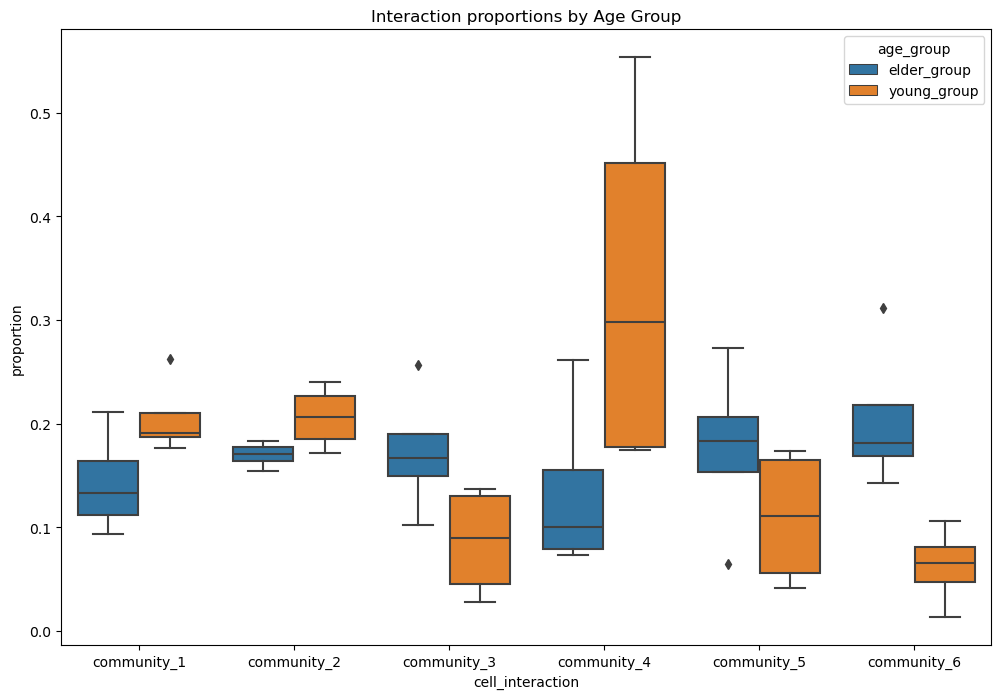

In [44]:
# Построение box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='cell_interaction', y='proportion', hue='age_group', data=df_3)
plt.title('Interaction proportions by Age Group')
plt.show()

## Нормальность выборки

In [45]:
normality_disperse_test(df_3, 'cell_interaction', 'proportion', 'age_group')

alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.13298708379409965
Распределение является нормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.09482355847633338
Распределение является нормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.10415514740306756
Распределение является нормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.09693438715886953
Распределение является нормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.1286424432527516
Распределение является нормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.16985191748819747
Распределение является нормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.1438163424860992
Распределение является нормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.09587549181306879
Распределение является нормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.14843950963258867
Распределение является нормальным
alpha: 0.05
Kolmogorov-Smirnov Test p-value: 0.1616889694460573
Распределение является нормальным
alpha: 0.05
K

In [46]:
# Проведение теста Левена для проверки гомогенности дисперсий
levene_test = stats.levene(df_3[df_3['age_group'] == 'young_group']
                           ['proportion'], df_3[df_3['age_group'] == 'elder_group']
                           ['proportion'])

# Вывод результата теста Левена
print(f'p-value: {levene_test.pvalue}')
if levene_test.pvalue > 0.05:
    print("Дисперсии в данных однородны (homogeneous)")
else:
    print("Дисперсии в данных неоднородны (non-homogeneous)")

p-value: 0.10489467656097472
Дисперсии в данных однородны (homogeneous)


## Статистический тест

In [47]:
# Проведение two-way ANOVA
model = ols('proportion ~ C(cell_interaction) + C(age_group) + C(cell_interaction):C(age_group)', data=df_3).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                        sum_sq    df             F    PR(>F)
C(cell_interaction)               6.309251e-02   5.0  2.062007e+00  0.093087
C(age_group)                      2.632104e-33   1.0  4.301159e-31  1.000000
C(cell_interaction):C(age_group)  1.524287e-01   5.0  4.981719e+00  0.001439
Residual                          2.203028e-01  36.0           NaN       NaN


# Задание 4

Правда ли, что иммунные клетки (*Immune type 1* и *Immune type 2*) лежат ближе к сосудам и крупным клеткам (Обе колонки *distance*), чем стромальные клетки (*Stroma cells*) у молодых, но не у пожилых пациентов? Эту гипотезу нужно проверить бутстрапом (как разницу средних для двух выборок).

In [48]:
def bootstrap_mean_difference(data1, data2, n_bootstrap=10000):
    bootstrap_diffs = np.empty(n_bootstrap)  # Предварительное выделение памяти
    for i in range(n_bootstrap):
        bootstrap_sample1 = np.random.choice(data1, size=len(data1), replace=True)
        bootstrap_sample2 = np.random.choice(data2, size=len(data2), replace=True)
        bootstrap_diffs[i] = bootstrap_sample1.mean() - bootstrap_sample2.mean()
    return bootstrap_diffs

# Фильтрация данных по типу клеток и возрастной группе
immune_young = df[(df['cell_type'].isin(['Immune type 1', 'Immune type 2'])) & (df['age_group'] == 'young_group')]
immune_elder = df[(df['cell_type'].isin(['Immune type 1', 'Immune type 2'])) & (df['age_group'] == 'elder_group')]
stroma_young = df[(df['cell_type'] == 'Stroma cells') & (df['age_group'] == 'young_group')]
stroma_elder = df[(df['cell_type'] == 'Stroma cells') & (df['age_group'] == 'elder_group')]

# Выполнение бутстрапа для оценки разницы средних расстояний до сосудов и крупных клеток
bootstrap_diffs_young_vasc = bootstrap_mean_difference(
    immune_young['distance_to_vasculature'].values, 
    stroma_young['distance_to_vasculature'].values
)

bootstrap_diffs_elder_vasc = bootstrap_mean_difference(
    immune_elder['distance_to_vasculature'].values, 
    stroma_elder['distance_to_vasculature'].values
)

bootstrap_diffs_young_largest = bootstrap_mean_difference(
    immune_young['distance_to_largest_cell'].values, 
    stroma_young['distance_to_largest_cell'].values
)

bootstrap_diffs_elder_largest = bootstrap_mean_difference(
    immune_elder['distance_to_largest_cell'].values, 
    stroma_elder['distance_to_largest_cell'].values
)

# Расчет 95% доверительного интервала для разницы средних
ci_95_young_vasc = np.percentile(bootstrap_diffs_young_vasc, [2.5, 97.5])
ci_95_elder_vasc = np.percentile(bootstrap_diffs_elder_vasc, [2.5, 97.5])
ci_95_young_largest = np.percentile(bootstrap_diffs_young_largest, [2.5, 97.5])
ci_95_elder_largest = np.percentile(bootstrap_diffs_elder_largest, [2.5, 97.5])

print(f'Разница для молодой группы до сосудов: {ci_95_young_vasc}')
print(f'Разница для старой группы до сосудов: {ci_95_elder_vasc}')
print(f'Разница для молодой группы до крупных клеток: {ci_95_young_largest}')
print(f'Разница для старой группы до крупных клеток: {ci_95_elder_largest}')

Разница для молодой группы до сосудов: [-28.79683059 -20.1649907 ]
Разница для старой группы до сосудов: [-31.35978077 -23.64891818]
Разница для молодой группы до крупных клеток: [-9.28582504 -4.41898188]
Разница для старой группы до крупных клеток: [-22.92401471 -16.59096137]


# Задание 5

Правда ли, что иммунные клетки в среднем лежат ближе к сосудам у молодых, но не у пожилых пациентов? Эту гипотезу необходимо проверить пермутационным тестом. В качестве исходной статистики берем массив с расстояниями только для данного типа клеток (длина - n), запоминаем среднее для каждого пациента. На каждой итерации набираем выборку размером n из всей! колонки с расстояниями до сосудов и смотрим соотношение с исходной статистикой. Проверяем гипотезы. Комбинировать p-values для каждой возрастной группы можно с помощью этого инструмента.

In [74]:
# Разделение на две выборки по возрасту
young_patients = df[df['age_group'] == 'young']
elderly_patients = df[df['age_group'] == 'elderly']

# Выборка только иммунных клеток
immune_1_patients = young_patients[young_patients['cell_type'] == 'Immune type 1']
immune_2_patients = young_patients[young_patients['cell_type'] == 'Immune type 2']

elderly_immune_1_patients = elderly_patients[elderly_patients['cell_type'] == 'Immune type 1']
elderly_immune_2_patients = elderly_patients[elderly_patients['cell_type'] == 'Immune type 2']

# Расчет среднего расстояния до сосудов для каждой выборки
def calculate_mean_distance(data):
    if len(data) > 0:
        return data['distance_to_vasculature'].mean()
    else:
        return 0  # или любое другое значение по умолчанию
    
# Расчет среднего расстояния до сосудов для каждой выборки
young_immune_1_mean_distance = calculate_mean_distance(immune_1_patients)
young_immune_2_mean_distance = calculate_mean_distance(immune_2_patients)

elderly_immune_1_mean_distance = calculate_mean_distance(elderly_immune_1_patients)
elderly_immune_2_mean_distance = calculate_mean_distance(elderly_immune_2_patients)

def permutation_test(pool1, pool2, num_permutations=10000): 
    observed_mean_diff = np.mean(pool1) - np.mean(pool2) 
    combined_pool = np.concatenate([pool1, pool2]) 
    mean_diffs = np.zeros(num_permutations) 
 
    for i in range(num_permutations): 
        permuted_pool = resample(combined_pool) 
        permuted_pool1 = permuted_pool[:len(pool1)] 
        permuted_pool2 = permuted_pool[len(pool1):] 
        mean_diffs[i] = np.mean(permuted_pool1) - np.mean(permuted_pool2) 
 
    p_value = np.sum(mean_diffs >= observed_mean_diff) / num_permutations 
    return p_value

# Проведение бутстрап-анализа для молодых пациентов
young_p_value = permutation_test(immune_1_patients['distance_to_vasculature'], immune_2_patients['distance_to_vasculature'])

# Проведение бутстрап-анализа для пожилых пациентов
elderly_p_value = permutation_test(elderly_immune_1_patients['distance_to_vasculature'], elderly_immune_2_patients['distance_to_vasculature'])
# Объединение p-значений
combined_p_value = stats.combine_pvalues([young_p_value, elderly_p_value], method='fisher')

# Вывод результатов
print(f"Young patients' p-value: {young_p_value}")
print(f"Elderly patients' p-value: {elderly_p_value}")
print(f"Combined p-value: {combined_p_value[1]}")

if combined_p_value[1] < 0.05:
    print("Гипотеза подтверждается.")
else:
    print("Гипотеза отвергается.")

Young patients' p-value: 0.0
Elderly patients' p-value: 0.0
Combined p-value: 0.0
Гипотеза подтверждается.
